![CC](https://i.creativecommons.org/l/by/3.0/88x31.png)

This work is licensed under a [Creative Commons Attribution 3.0 International License](http://creativecommons.org/licenses/by/3.0/).

# About this repository
This student thesis project aims to implement a model-based deep reinforcement learning algorithm for controlling the flow past a cylinder. The [drlfoam](https://github.com/OFDataCommittee/drlfoam) repository, which already provides a model-free version is herefore used as a starting point. A complete documentation of the work done in this project can be found in the [report](https://github.com/JanisGeise/robust_MB_DRL_for_flow_control) section of the *Readme* file, as well as the references used (it is also recommended to check out the [references](https://github.com/JanisGeise/robust_MB_DRL_for_flow_control) section at the bottom of the *Readme* file). The following notebook will give a brief summary of this report as well as an introduction about how to use this repository. In case contents of this notebook are not rendered correctly in Github, e.g. tables, please download and open this notebook locally using *jupyter-lab*. <br><br>
This repository contains the three main directories:
- *mb_drl*:
    - The *mb_drl* directory contains all altered and added scripts of *drlfoam* in order to modify the MF-DRL algorithm towards an MB-version. These scripts can e.g. be downloaded and pasted into an existing (local) *drlfoam* version. Alternatively, a full MB-version of the *drlfoam* repository can be found [here](https://github.com/JanisGeise/drlfoam), which was forked from the [original drlfoam](https://github.com/OFDataCommittee/drlfoam) repository. <br><br>
- *test_env_models*:
    - The *test_env_models* directory provides scripts to test different ways of training- and testing environment models on the data generated by the (original) model-free DRL-algorithm. Prior using these scripts, a model-free training needs to be executed. Suggestions and advises on how to efficiently run a model-free training in drlfoam will be discussed in [section 3](#MF_training). Once the training data is generated, the *train_environment_model.py* script can be used to test the following configurations:
        - train one global environment model for all the training data, without taking the episode into account    
        - train one environment model for predicting $c_l$ and $p_i$ and another model for predicting $c_d$. These models are also trained on all the data available, despite considering the episode in which the data was generated
        - the same as the two aforementioned options, but this time the environment model (or models) are trained for each new episode. This means two consecutive episodes are taken for training the models(s), then these model(s) are used to predict the next episode
        - these four options are covering therefore all extrema, namely having either one model performing averagly over all episodes or highly specialized models performing well, but only for the specific episode they are trained for. In reality, one would now make a compromise between these two extrema, as it is done in the current implementation of the MB-DRL algorithm
        - an option for training the environment models with low-passed filtered trajectories for $c_d$, this has found to have only little effect on the results
        - options for fine-tuning the models, such as the number of time steps used as input, number of hidden layers, number of neurons and length of the trajectories
        - an option to predict the change of state rather than predicting the next state. This option produces complete unrealistic results for the trajectories of $c_l$ and $p_i$ and is therefore not recommended to use
        - the following table sums up the available options, which can be set in the *setup* dict of the *train_environment_model.py* script:  
        | option         |                     description                         | default / recommended value |  
        | ---            |                         ---                             |               ---           |  
        | load_path      | path to the training data generated with MF-DRL         | ../drlfoam/examples/test_training/ |  
        | path_to_probes | path to the location of the probe data, this normally should be the same for all cases | base/postProcessing/probes/0/ |  
        | model_dir      | directory where to run the script                       | test_env_models/ |  
        | episode_depending_model | either one global model for whole data set or a new model / new models is trained for each episode, based on the previous two episodes | False |  
        | two_env_models | if *True*: one model only for predicting $c_d$, another for $p_i$ and $c_l$; *False*: only one model for all three parameters                   | True  |  
        | print_temp     | print core temperatur of processor as info                                            | False |  
        | normalize      | if *True*: data will be normalized to interval of [1, 0] for training and predictions | True  |  
        | smooth_cd      | flag if $c_d$-trajectories should be filtered after loading (low-pass filter)         | False |  
        | predict_ds     | predict the change of state, not the next state itself                                | False |  
        | n_input_steps  | initial time steps as input for the environment models, need to be $n_t \gt 1$        | 30 |  
        | len_trajectory | trajectory length for training the environment model, this option can be set independently of the trajectory length used in MF-DRL for creating the data. <br>The only prerequisite is, that *len_trajectory* $\%$ *length_trajectory(MF-DRL)* $== 0$                              | 200 |  
        | ratio          | splitting ratio for train-, validation and test data, for episode-wise models. <br>The test data ratio needs to be set to zero since the each next episode is used as test data                                                                                                | (0.65, 0.3, 0.05) <br> (0.65, 0.35, 0.0)|  
        | epochs         | number of epochs to run for the environment model, if *two_env_models* then this refers to the model for $c_l$ and $p_i$        | 10 000 |  
        | n_neurons      | number of neurons per layer for the environment model, if *two_env_models* then this refers to the model for $c_l$ and $p_i$    | 50 |
        | n_layers       | number of hidden layers for the environment model, if *two_env_models* then this refers to the model for $c_l$ and $p_i$        | 3 |  
        | n_neurons_cd   | number of neurons per layer for the environment model for cd (if option *two_env_models* is set to *True*) | 50 |  
        | n_layers_cd    | number of hidden layers for the environment model for cd (if option *two_env_models* is set to *True*)     | 5 |  
        | epochs_cd      | number of epochs to run for the environment model for cd (if option *two_env_models* is set to *True*)     | 10 000 |  
        <br> 
    - Further, within this directory are scripts to post-process and visualize all results and data created, as well as conducting parameter studies with respect to the influence of the model architecture or number of time steps as input.<br> <br> 
- *scripts_py_plots*:
    - this directory provides scripts for post-processing all results generated over the course of the training (MB-DRL as well as MF-DRL)
    - various scripts for conducting parameter studies and visualizing data of these parameter studies, e.g. investigting the influence of the buffer size and trajectory length as shown in [section 3](#MF_training)

# Active flow control and numerical setup
This section briefly discusses the general flow problem to solve and the numerical setup. As the name suggests, *drlfoam* uses the open-source CFD software [OpenFOAM](https://www.openfoam.com/), currently in the version *v2206*.

## General flow problem
The *drlfoam* package aimes to control the flow past a cylinder using deep-reinforcement learning. The flow is unsteady and incompressible, the default Reynolds number is set to $Re = 100$. As depiced in the following figures, without flow control vortex shedding, formally known as Kármán vortex street, developes. During training, the agent tries to learn a control law by rotating the cylinder with the goal to minimize $c_l$ and $c_d$. A comparison of the uncontrolled flow past a cylinder with the controlled flow, both at a Reynolds number of $Re = 100$, illustrates the effect of active flow control:
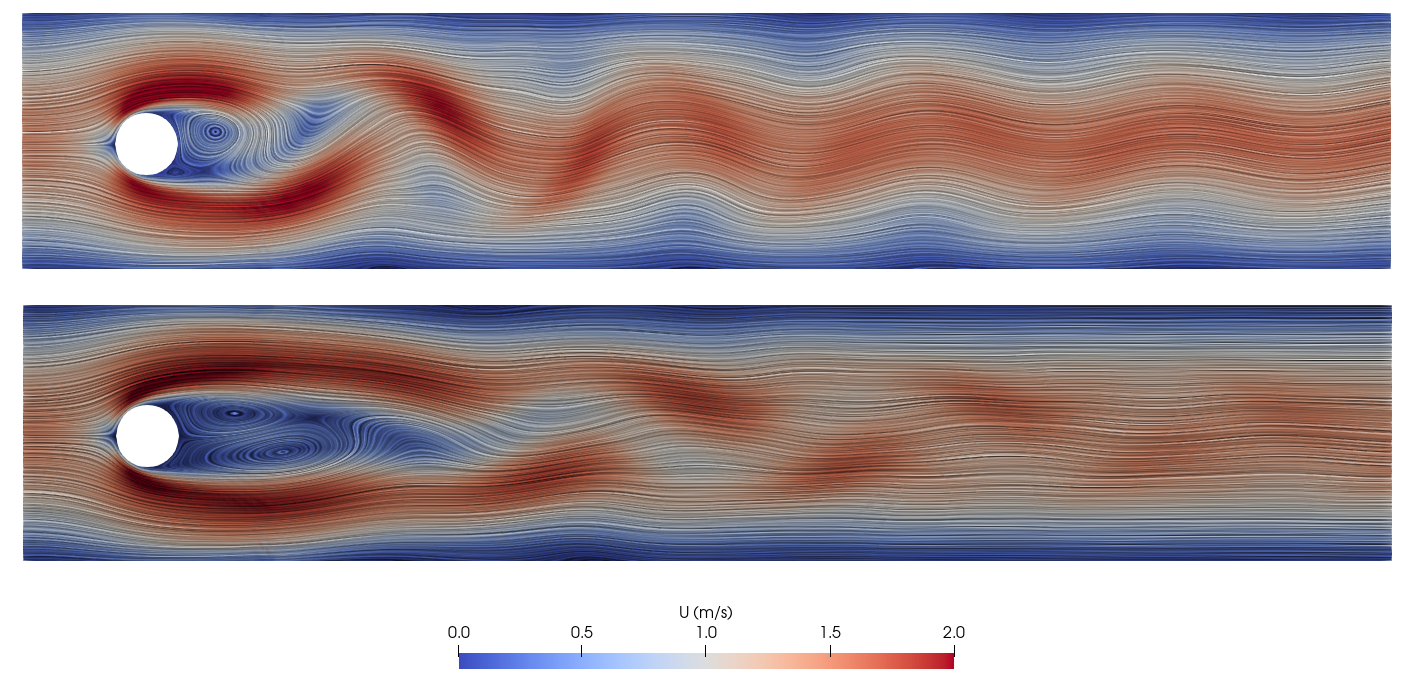

The upper figure shows the uncontrolled flow while in the lower figure active flow control was applied. Clearly it can be seen that by rotating the cylinder in an optimal way, the vortex shedding can be reduced significantly.

## Numerical setup
The descirbed flow problem is unsteady, therefore the transient, incompressible solver [pimpleFoam](https://www.openfoam.com/documentation/guides/latest/doc/guide-applications-solvers-incompressible-pimpleFoam.html) is used. The cylinder has a default diameter of  $d = 0.1m$, the free stream velocity is $U_{\infty} = 1 m/s$. During the simulation, $c_l$ and $c_d$ at the cylinder surface are written out as well as pressure values $p_i$ at defined positions within the flow field. In the default setup, the number of probes is set to $12$, which are all placed in the wake of the cylinder as depicted in the following plot:
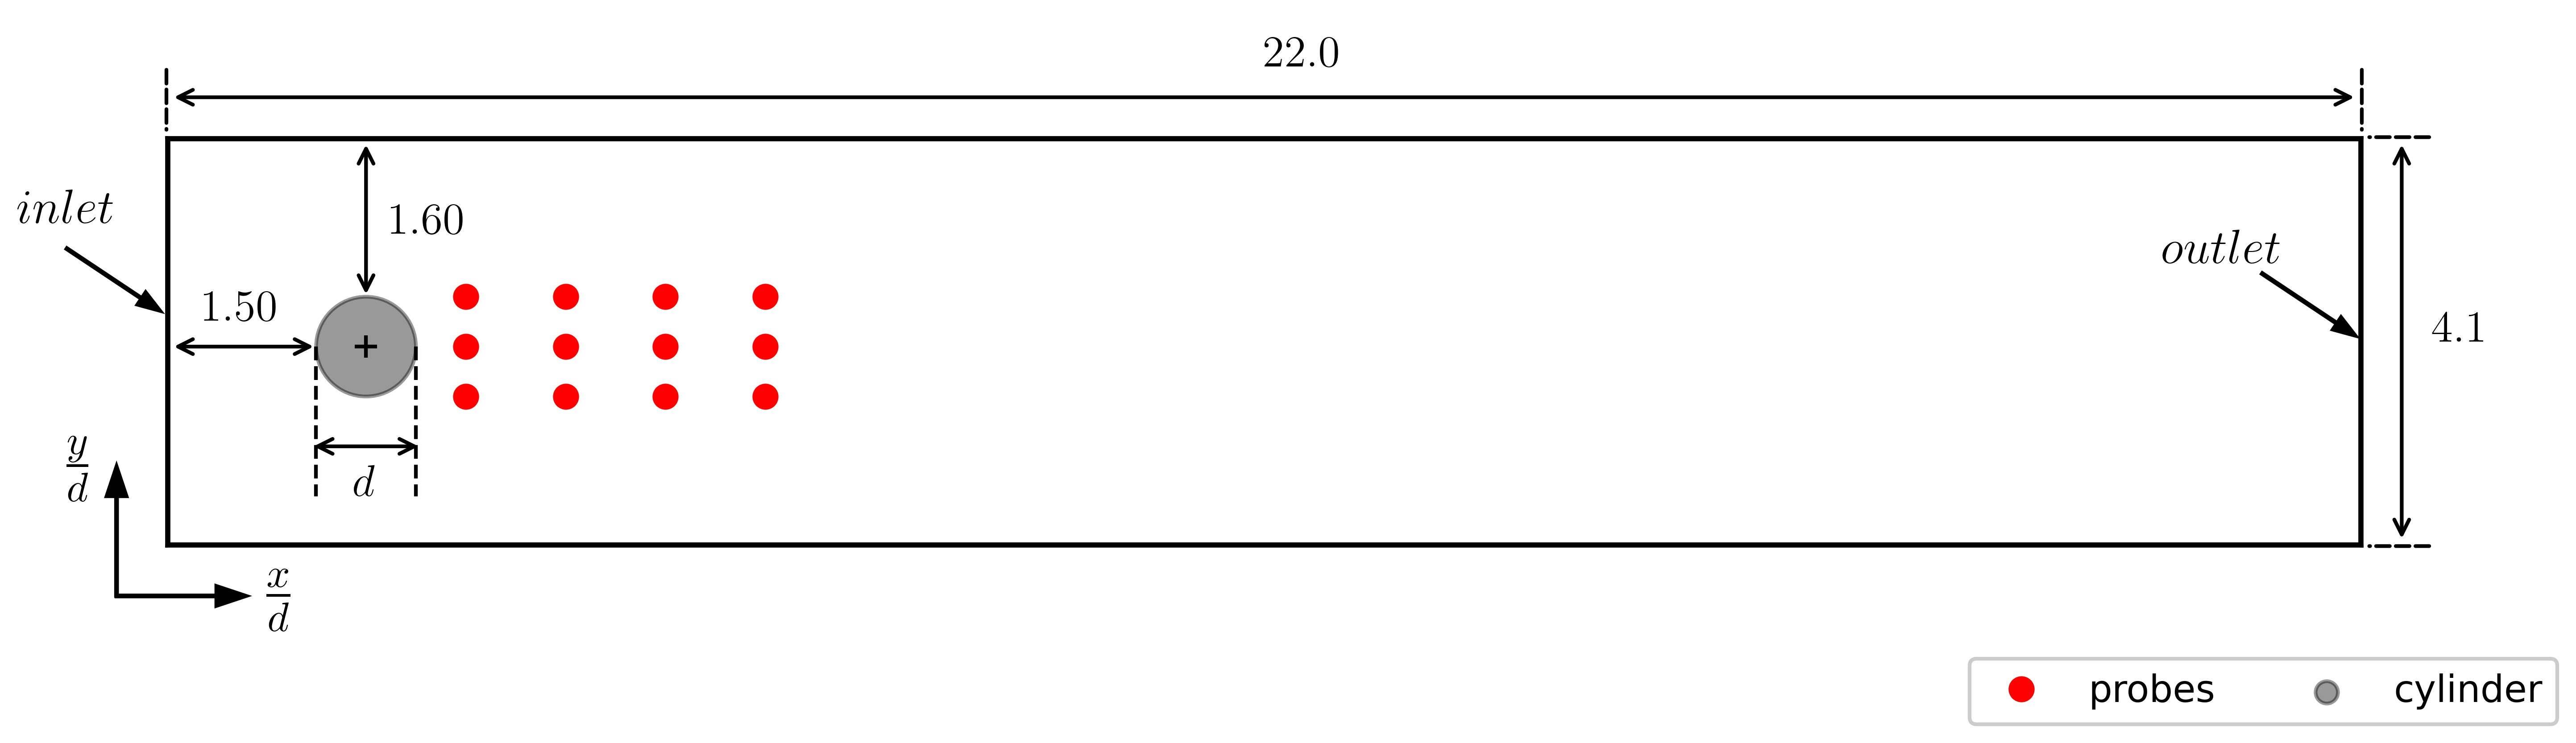
**Note:** in all the scripts, e.g. for post-processing, the pressure values at the probe locations are usually refered to as *states*, since these values are used at input into the policy network.

# Choosing optimal parameters for a model-free training (MF-DRL) <a id="MF_training"></a>

When running a model-free training, there are mainly three parameters which control the outcome of the training. The first parameter is the buffer size, determining how many trajectories should be generated within each episode, this parameter is named *-b* in the *run_training.py* script. The second parameter is the length of the trajectory *-f*. It is important to note that the first $4s$ are uncontrolled (base case), therefore, the length of the trajectory (in the following *l* ) is always $l = f - 4s$ with $f$ denoting the parameter *f*  in the *run_training.py* script. Lastly, the number of episodes to run (parameter *-i* ) can be defined. The number of runners *-r* defines the number of parallel executions and should ideally be set equal to the buffer size (provided the hardware is not restricting the number of parallel processes). <br><br>
The setup for a model-free training is highly depending on the available resources. On a cluster like the [HPC](https://www.tu-braunschweig.de/it/dienste/21/phoenix) of TU Braunschweig, the buffer size is recommended to be set to $b=10$ and the trajectory length to $l=6s$ ($\cong f=10$). The training should then converge after around $i = 80$ episodes and approximately $9$ hours. When running a training on a local machine, this setup is not feasible to run in a realisitc amount of time, however, a buffer size of $b=4$, trajectory length of $l=2s$ ($\cong f=4$) can be run on a *Intel <sup>R</sup> Core<sup>TM</sup> i7-11800H* with $8$ cores in about $22h:30min$ (also for $i = 80$ episodes). <br><br>
The following plots shall give an overview on how the performance is affected by the aforementioned parameters. To make the results independent of the available computational resources, all data are scaled to an interval of $[0, 1]$ using a min-max scaling. Consequently, changes within parameters are to be interpreted relative to each other. The reward function is defined as $r(c_d, c_l) = 3 - (c_d + 0.1 * | c_l |)$ with $r$ denoting the *reward* and therefore a measure of the performance of the agent over the course of the training. The computational costs on the other hand are taken into account by the required run time *t*.  In the following figures, $\mu$ refers to the mean values averaged over three different seeds and all episodes, while $\sigma$ denotes the corresponding standard deviation. All cases are run for $80$ episodes, ensuring the comparability when using the rewards averaged over all episodes.<br><br>
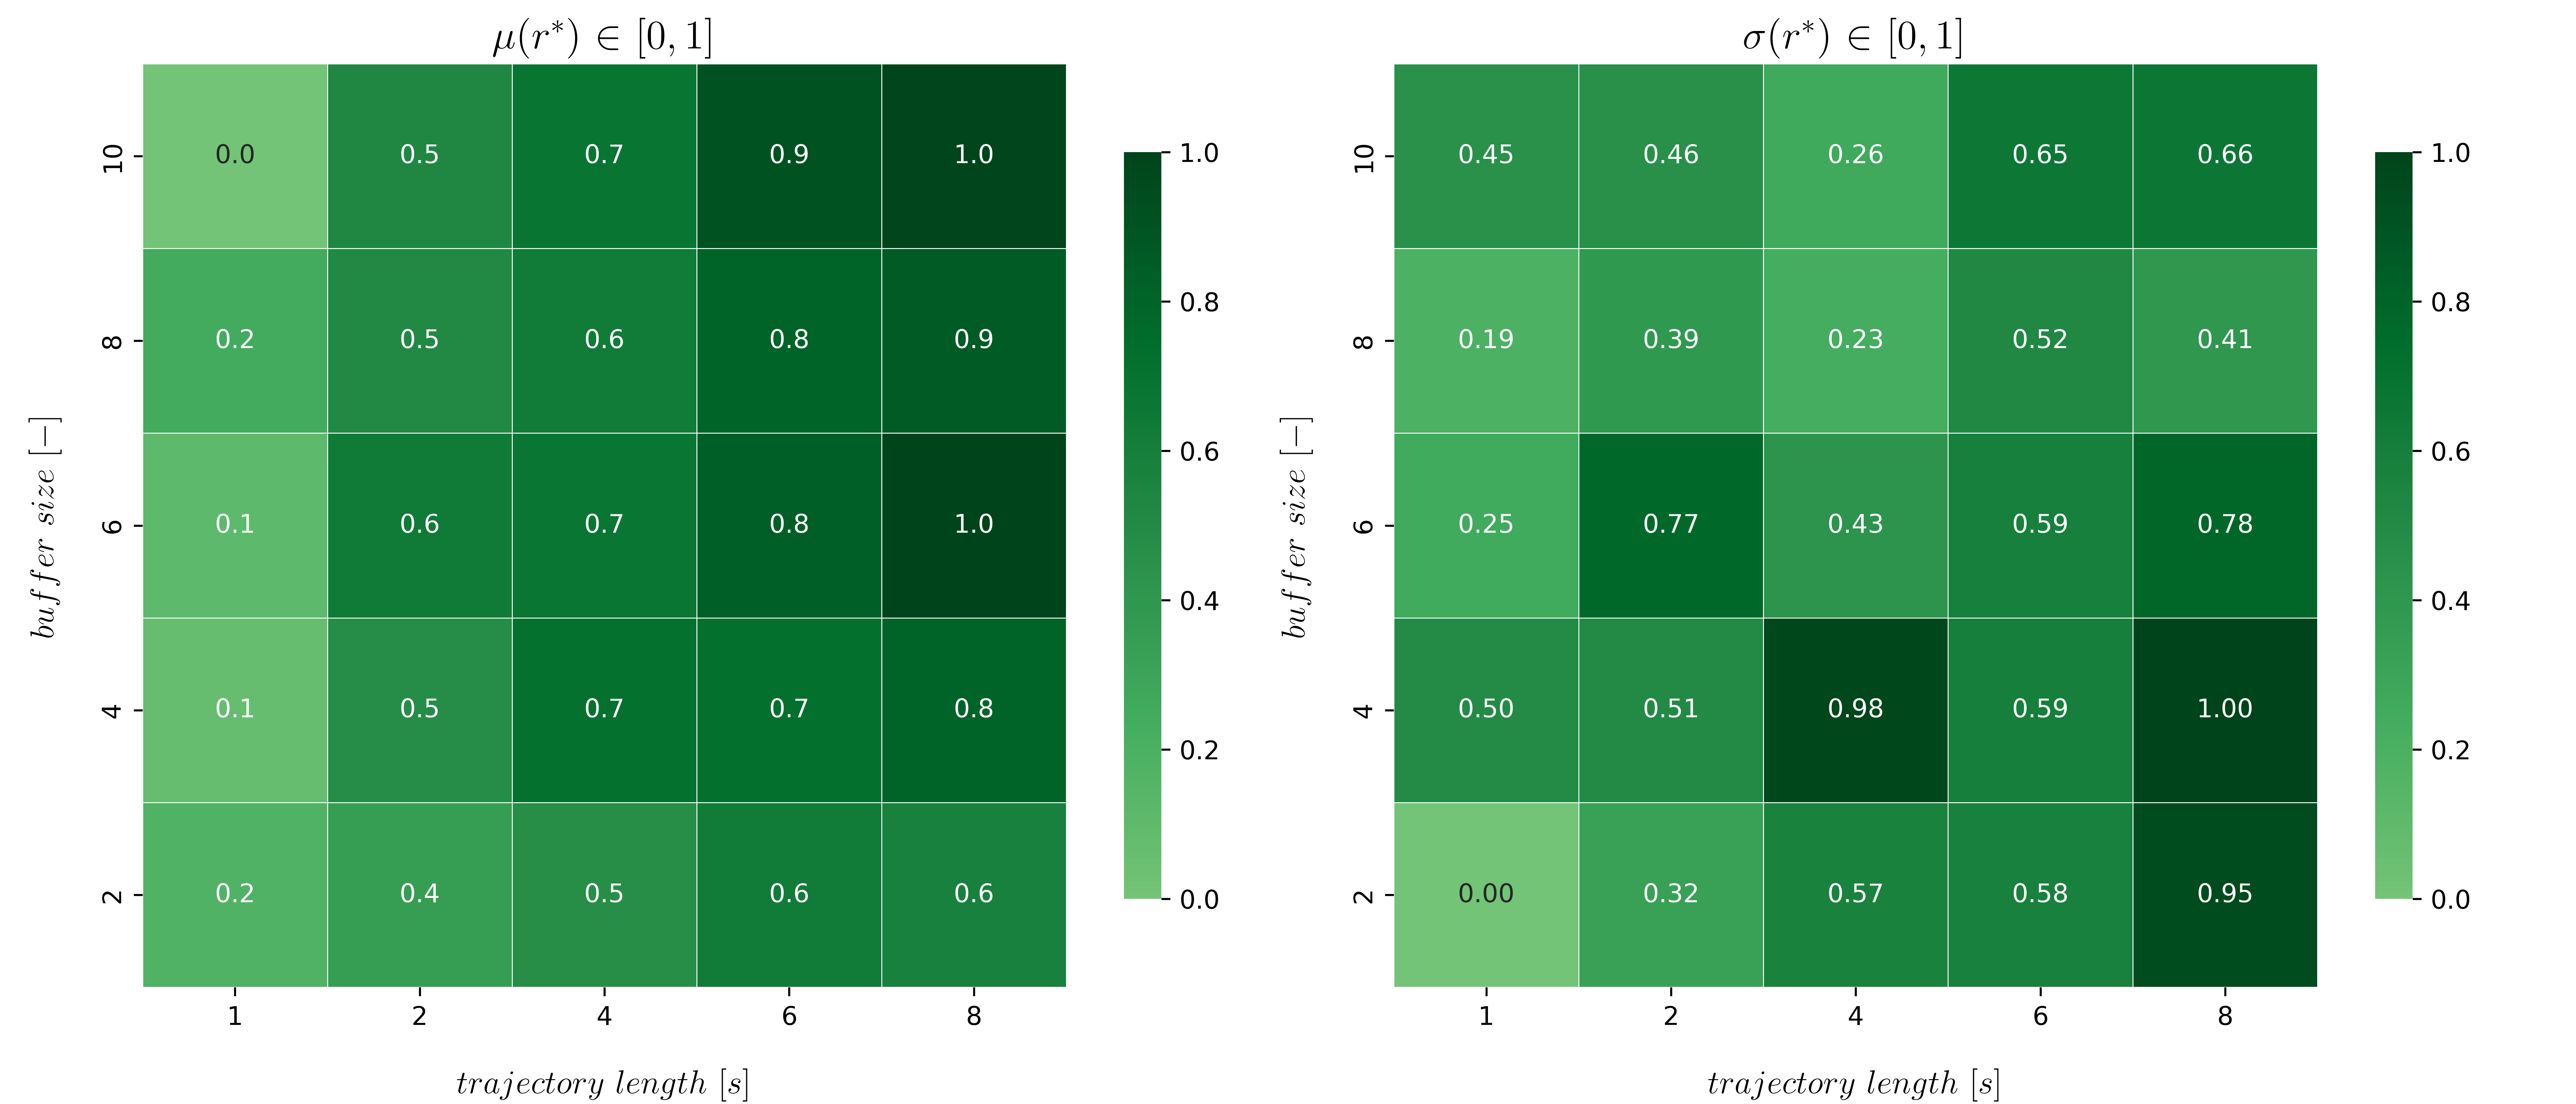
<br><br>
The buffer size has only little effect, as can be seen by the rewards. Therefore, it is recommended to reduce the buffer size in favour of an increased trajectory length if the computational resources are a limiting factor. The runtime, however, increases significantly when increasing the trajectory length from $l=6s$ to $l=8s$. Trajectory lengths of $l \ge 8s$ have no siginificant effect on the resulting performance leading mainly to an increase of the run times. Further, running a training for more than $80$ episodes may improve the results in some cases but in general the training should converge after $80$ episodes.<br><br>
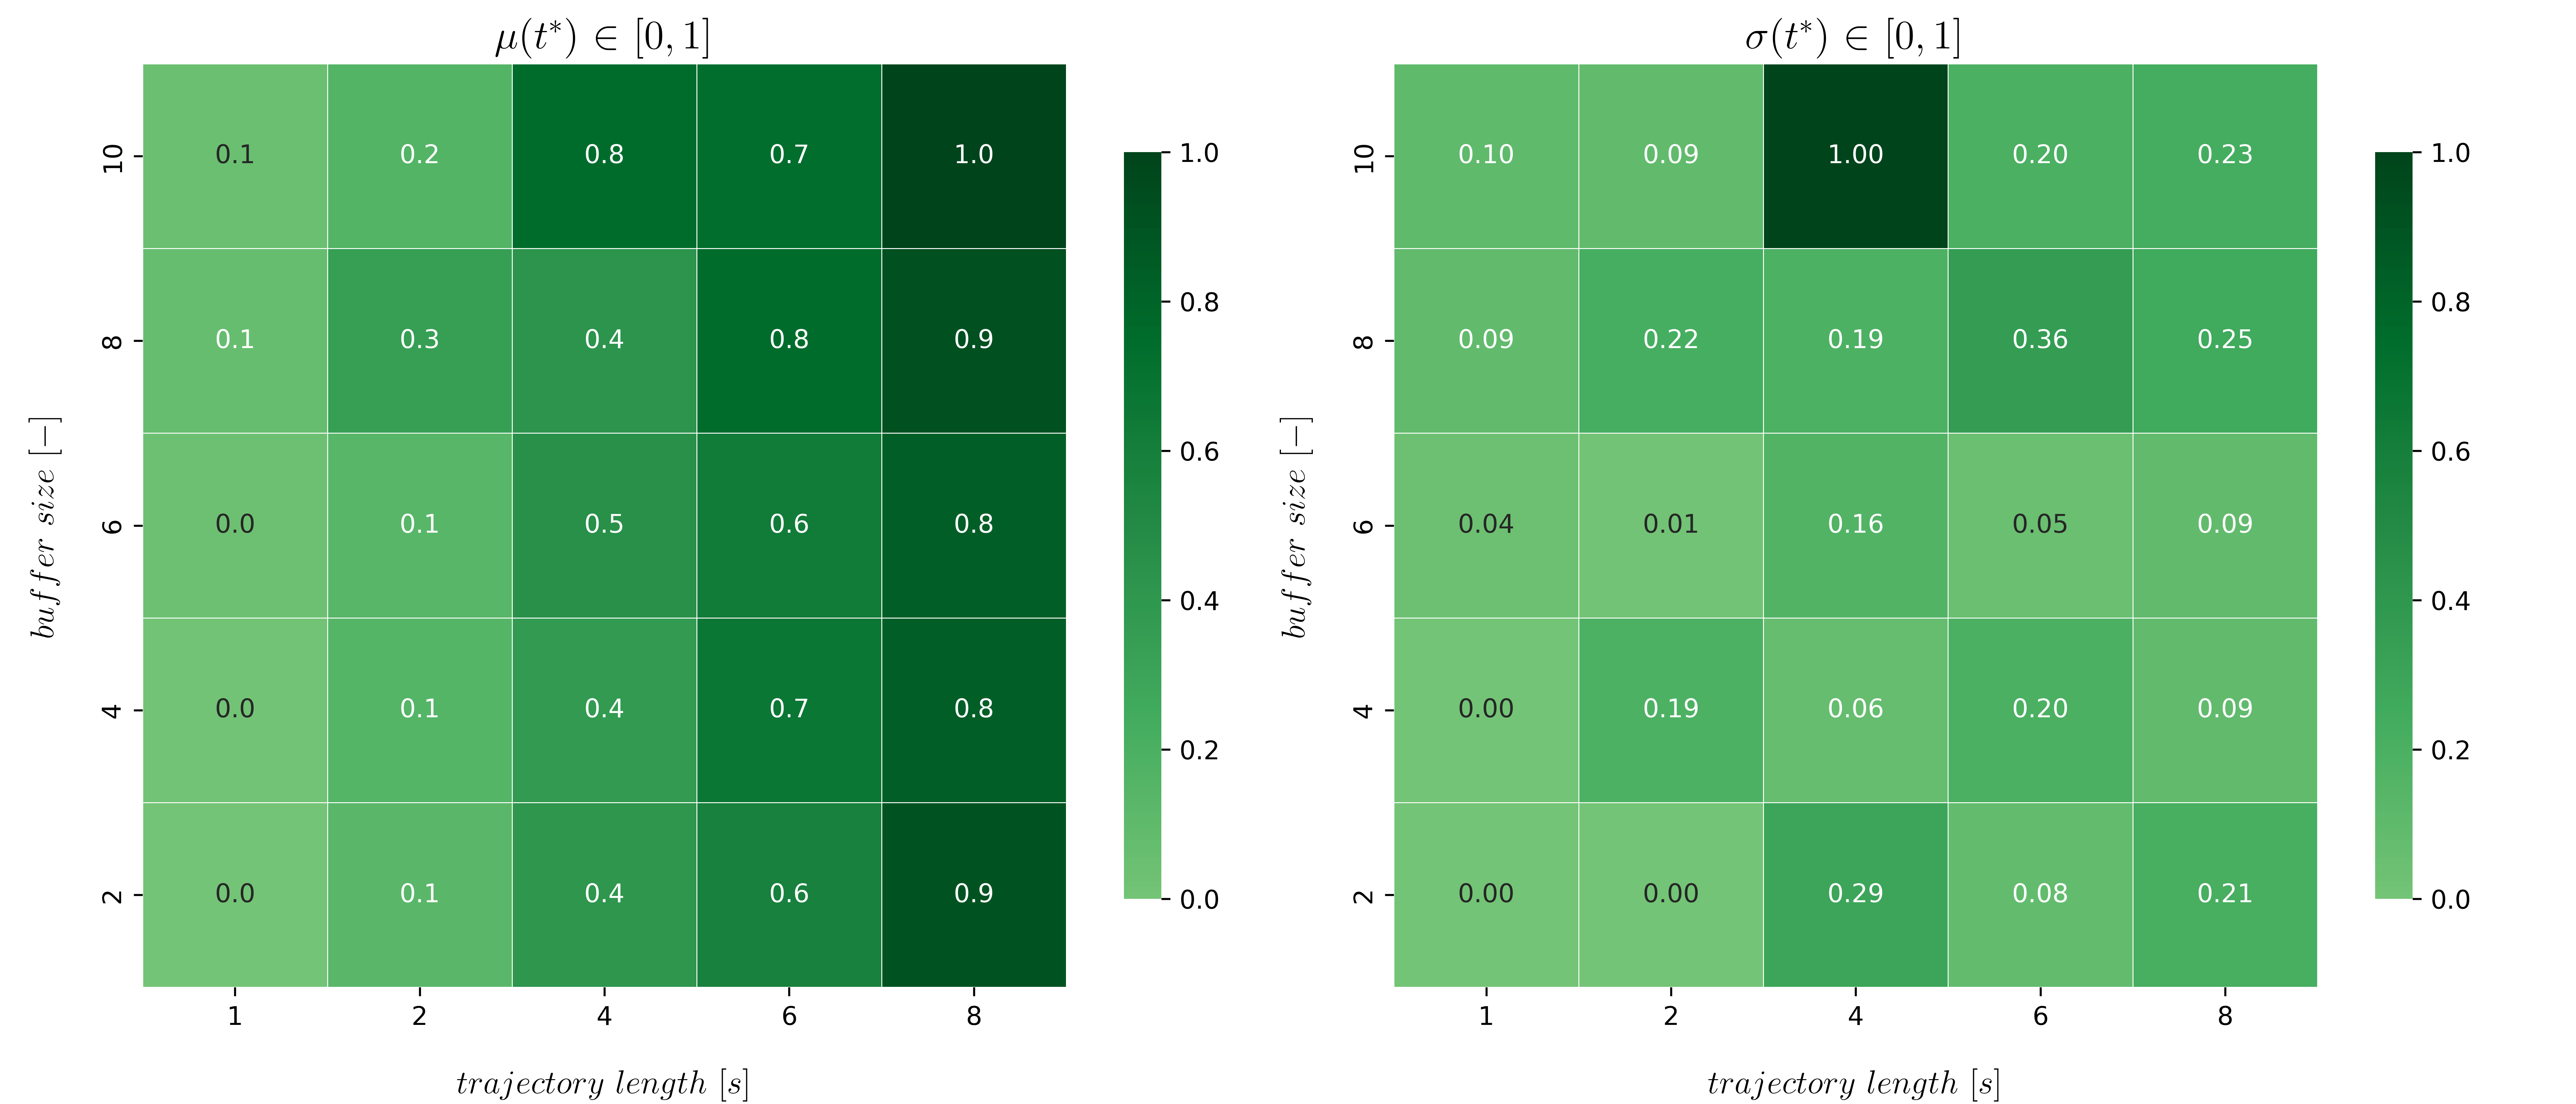

# Running a training using environment models (MB-DRL)